In [1]:
from spektral.layers import GCNConv

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dropout, Dense
from tensorflow.keras import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import TensorBoard, EarlyStopping
import tensorflow as tf
from tensorflow.keras.regularizers import l2
import pandas as pd

In [2]:
import numpy as np
import scipy.sparse as sp
import tensorflow as tf
from tensorflow.keras.layers import Dense, Input, BatchNormalization
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.metrics import categorical_accuracy
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

from spektral.data import Dataset, DisjointLoader, Graph
from spektral.layers import GCSConv, GlobalAvgPool, ChebConv, GlobalSumPool
from spektral.layers.pooling import TopKPool
from spektral.transforms.normalize_adj import NormalizeAdj
import pickle as pkl
import networkx as nx
import pdb
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical

In [5]:

learning_rate = 1e-2  # Learning rate
epochs = 1000  # Number of training epochs
es_patience = 10  # Patience for early stopping
batch_size = 3  # Batch size


import sys
from spektral.data import Dataset, Graph
# sys.path.append('../lib')
# from data_pre_processing import load_data
# sys.path.remove('../lib')
from spektral.layers import GCNConv, GraphSageConv
from spektral.models.gcn import GCN
from spektral.transforms import AdjToSpTensor, LayerPreprocess
from sklearn.preprocessing import MinMaxScaler


x_data = []
y_data = []

def load_data(circuit_name, path_to_data="data", normalize=False):
    """Load data."""
    names = ["x", "y", "graph"]
    objects = []
    for i in range(len(names)):
        with open(f"{path_to_data}/{circuit_name}.{names[i]}", "rb") as f:
            if sys.version_info > (3, 0):
                objects.append(pkl.load(f, encoding="latin1"))
            else:
                objects.append(pkl.load(f))

    x, y, graph = tuple(objects)
    
    x = np.array(x).astype("float32")
    for x_feat in x:
        x_data.append(x_feat)
        
    features = sp.csr_matrix(x).astype('float32')
    # adj = nx.adjacency_matrix(nx.from_dict_of_lists(graph)).astype(int)
    g = nx.DiGraph()
    g.add_nodes_from(graph.keys())
    for k, v in graph.items():
      g.add_edges_from(([(k, t) for t in v]))
      g.add_edges_from([(k, k)])
    adj = nx.adjacency_matrix(g)
    labels = np.array(y).astype('float32').reshape((-1,1))
    for l in y:
        y_data.append(l)
    print(adj.shape)
    print(features.shape)
    return adj, features, labels
  
def encode_label(labels):
    label_encoder = LabelEncoder()
    labels = label_encoder.fit_transform(labels)
    labels = to_categorical(labels)
    return labels


def _preprocess_features(features):
    rowsum = np.array(features.sum(1))
    r_inv = np.power(rowsum, -1).flatten()
    r_inv[np.isinf(r_inv)] = 0.0
    r_mat_inv = sp.diags(r_inv)
    features = r_mat_inv.dot(features)
    return features



class CircuitDataset(Dataset):
    def read(self):
        circuits = []
#         circs = ['c6288','c5315','c432', 'c499', 'c17', 'c880', 'c1355', 'c1908', 'c3540', 'adder.bench', 'arbiter.bench', 'cavlc.bench', 'dec.bench', 'voter.bench', "sin.bench","priority.bench", "multiplier.bench", "max.bench"]
        circs = ["adder.bench","arbiter.bench","c1355","c1908","c3540","c432","c499","c5315","c6288","c880","cavlc.bench","dec.bench","int2float.bench","max.bench","multiplier.bench","priority.bench","sin.bench","voter.bench", "i2c", "router", "ctrl"]
#         circs = ["log2.bench"]
#         circs = ['adder.bench', "arbiter.bench",  "sin.bench", "multiplier.bench", "voter.bench", "priority.bench"]
        for circ in circs:
            A, X, labels = load_data(circ, 'output', normalize="")
#             if sum(labels) >= 500:
            print(f"{circ}: {sum(labels)}, {len(labels)}")
#             scaler = MinMaxScaler()
#             X = scaler.fit_transform(X.toarray())
            circuits.append(Graph(x=X.toarray(), a=A, y=labels))

        return circuits


dataset = CircuitDataset()


# Train/valid/test split
np.random.seed(42)
idxs = np.random.permutation(len(dataset))
split_va, split_te = int(0.8 * len(dataset)), int(0.9 * len(dataset))
idx_tr, idx_va, idx_te = np.split(idxs, [split_va, split_te])
print(idx_tr, idx_va, idx_te)
dataset_tr = dataset[idx_tr]
dataset_va = dataset[idx_va]
dataset_te = dataset[idx_te]
def load_tr_data(epochs=400):
    loader_tr = DisjointLoader(dataset_tr, batch_size=batch_size, epochs=epochs, node_level=True)
    loader_va = DisjointLoader(dataset_va, batch_size=batch_size, node_level=True)
    loader_te = DisjointLoader(dataset_te, batch_size=batch_size, node_level=True)
    return loader_tr, loader_va, loader_te

loader_tr, loader_va, loader_te = load_tr_data()


(4209, 4209)
(4209, 4)
adder.bench: [637.], 4209
(36352, 36352)
(36352, 4)
arbiter.bench: [3763.], 36352
(1355, 1355)
(1355, 4)
c1355: [192.], 1355
(1908, 1908)
(1908, 4)
c1908: [257.], 1908
(3540, 3540)
(3540, 4)
c3540: [406.], 3540
(432, 432)
(432, 4)
c432: [60.], 432
(499, 499)
(499, 4)
c499: [50.], 499
(5315, 5315)
(5315, 4)
c5315: [599.], 5315
(6288, 6288)
(6288, 4)
c6288: [846.], 6288
(880, 880)
(880, 4)
c880: [114.], 880
(2164, 2164)
(2164, 4)
cavlc.bench: [318.], 2164
(936, 936)
(936, 4)
dec.bench: [186.], 936
(761, 761)
(761, 4)
int2float.bench: [80.], 761
(9996, 9996)
(9996, 4)
max.bench: [1040.], 9996
(89943, 89943)
(89943, 4)
multiplier.bench: [9294.], 89943
(3495, 3495)
(3495, 4)
priority.bench: [350.], 3495
(16771, 16771)
(16771, 4)
sin.bench: [1723.], 16771
(50122, 50122)
(50122, 4)
voter.bench: [5012.], 50122
(4107, 4107)
(4107, 4)
i2c: [502.], 4107
(945, 945)
(945, 4)
router: [99.], 945
(569, 569)
(569, 4)
ctrl: [92.], 569
[ 0 17 15  1  8  5 11  3 18 16 13  2  9 20  4 

In [6]:
df = pd.DataFrame(np.vstack(np.array([gr.x for gr in dataset_tr])), columns=['level', 'c0', 'c1', 'ob'])
df['y'] = np.vstack(np.array([gr.y for gr in dataset_tr]))

<ipython-input-6-a822f0d4e3e0>:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  df = pd.DataFrame(np.vstack(np.array([gr.x for gr in dataset_tr])), columns=['level', 'c0', 'c1', 'ob'])
<ipython-input-6-a822f0d4e3e0>:2: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  df['y'] = np.vstack(np.array([gr.y for gr in dataset_tr]))


In [7]:
def stratified_sample_df(df, col, n_samples):
    n = min(n_samples, df[col].value_counts().min())
    df_ = df.groupby(col).apply(lambda x: x.sample(n))
    df_.index = df_.index.droplevel(0)
    return df_

In [8]:
import numpy as np
from sklearn.manifold import TSNE
df_1000 = stratified_sample_df(df, 'y', 10000)
X_embedded = TSNE(n_components=2).fit_transform(df_1000[:-1])
X_embedded.shape

(19999, 2)

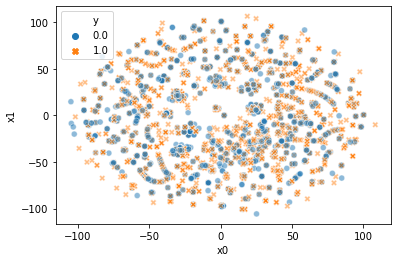

In [9]:
import seaborn as sns
df_tsne = pd.DataFrame(X_embedded, columns=['x0', 'x1'])
df_tsne['y'] = df_1000['y']
sns.scatterplot(data=df_tsne, x="x0", y="x1", hue="y", style="y", alpha=0.5)

level

c0

c1

ob



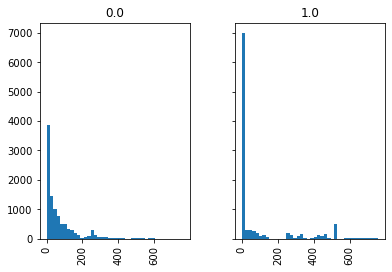

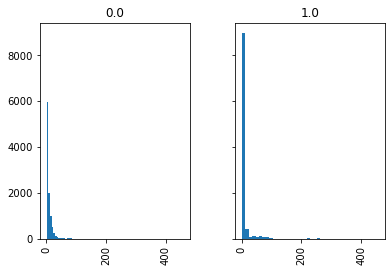

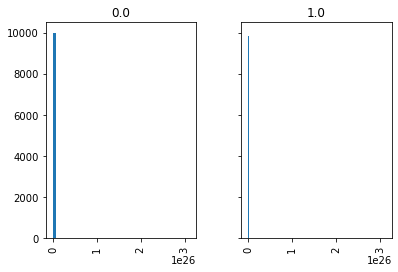

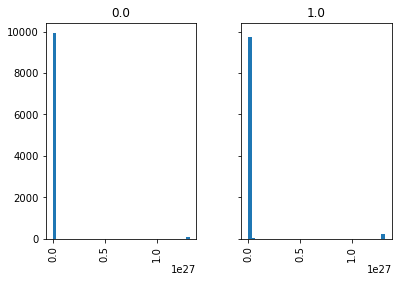

In [10]:
for col in ['level', 'c0', 'c1', 'ob']:
    print(col)
    df_1000.hist(by='y', column=col, bins=40, sharex=True, sharey=True)
    print('')

----------------0-----------------


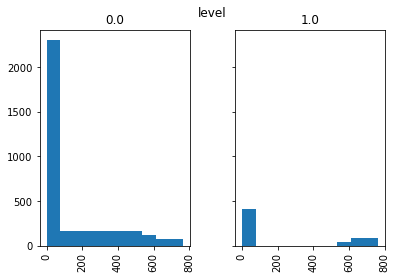

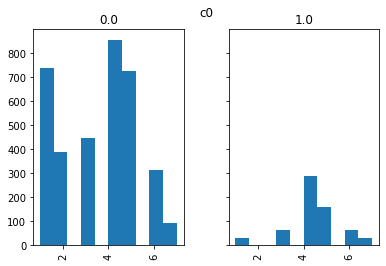

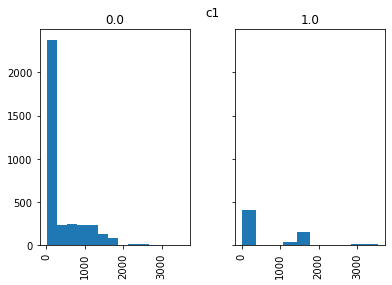

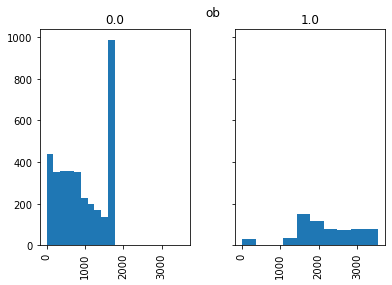

----------------1-----------------


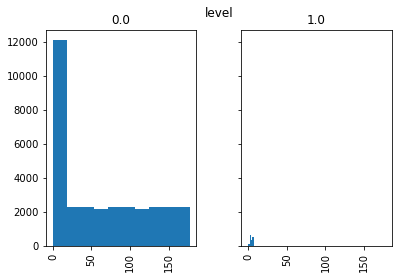

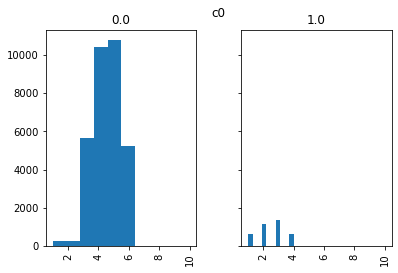

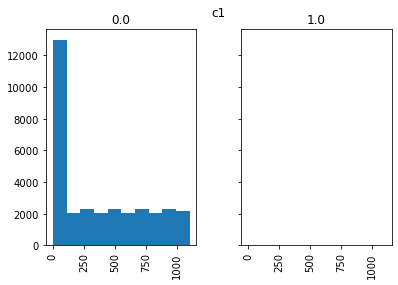

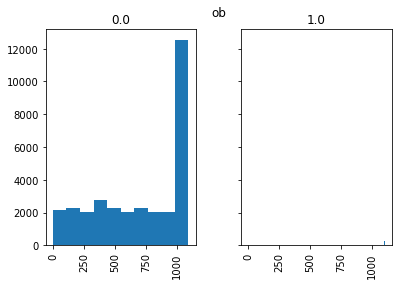

----------------2-----------------


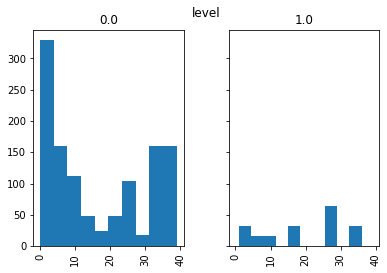

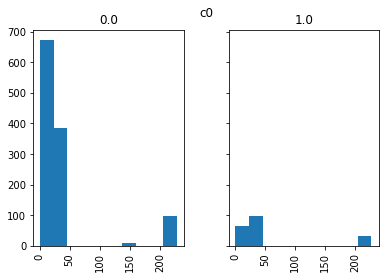

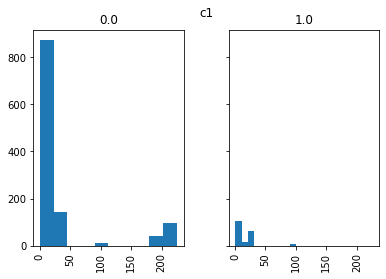

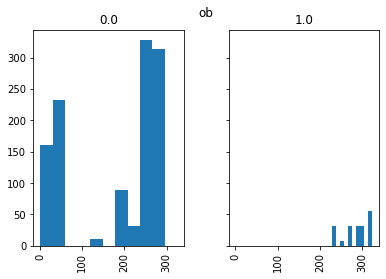

----------------3-----------------


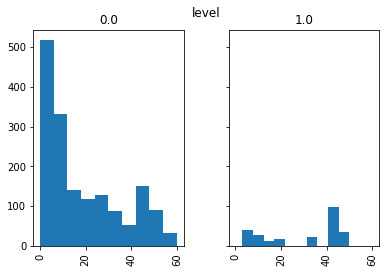

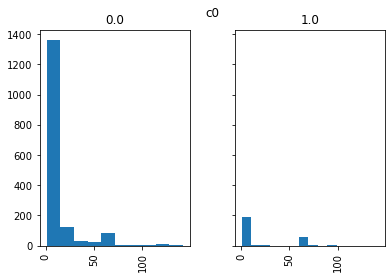

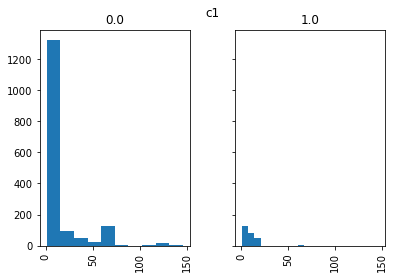

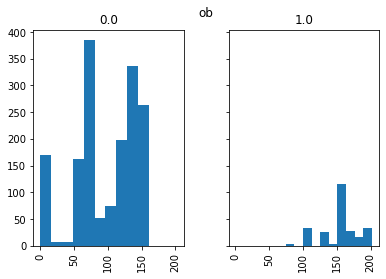

----------------4-----------------


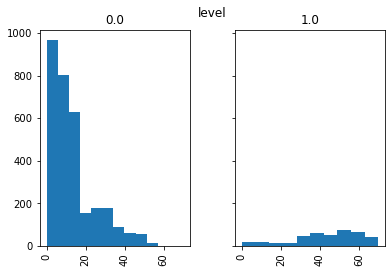

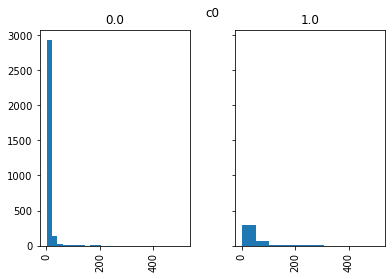

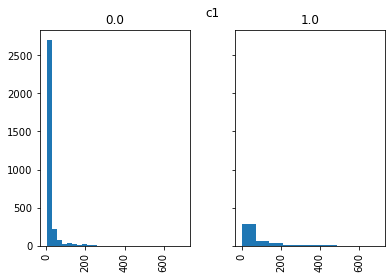

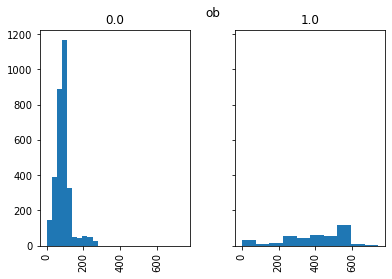

----------------5-----------------


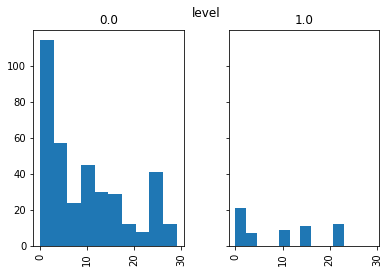

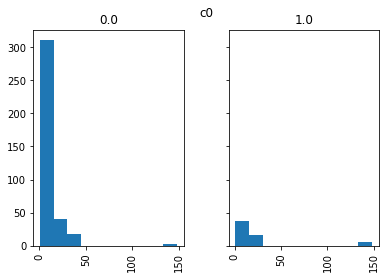

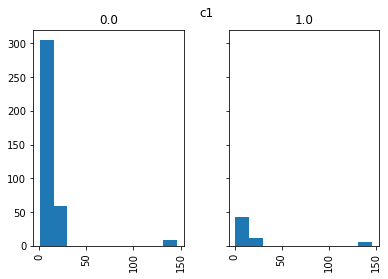

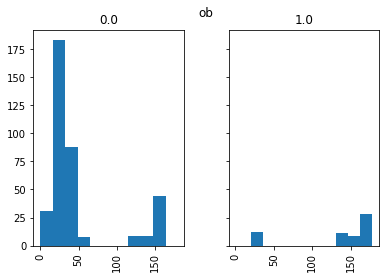

----------------6-----------------


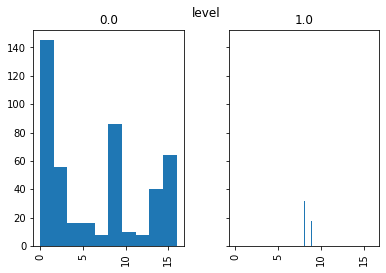

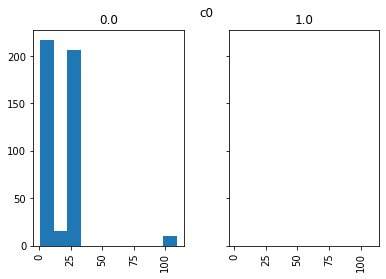

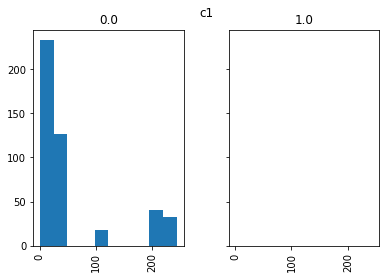

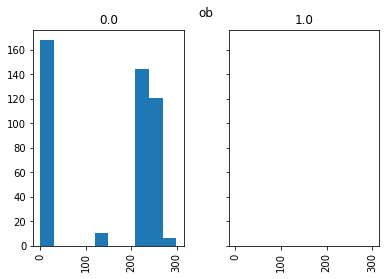

----------------7-----------------


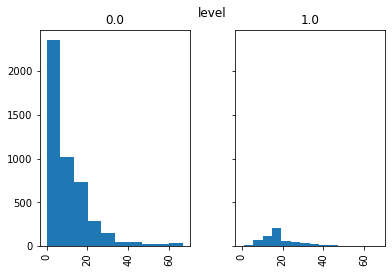

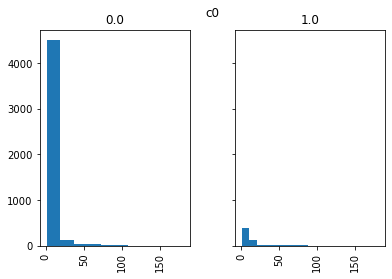

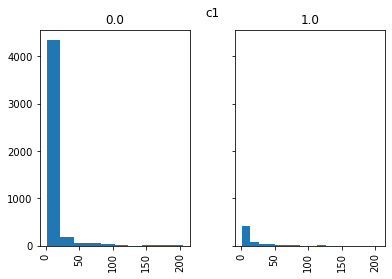

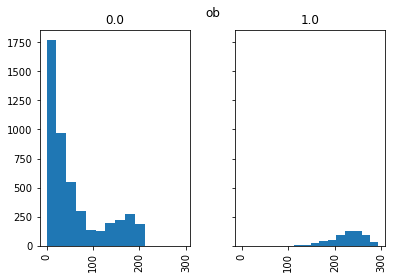

----------------8-----------------


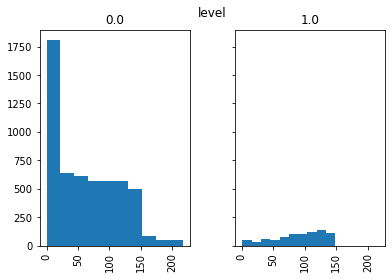

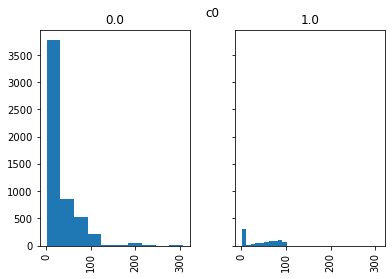

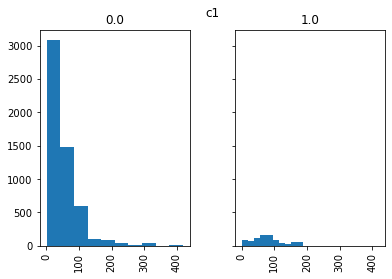

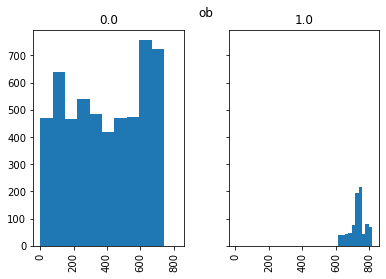

----------------9-----------------


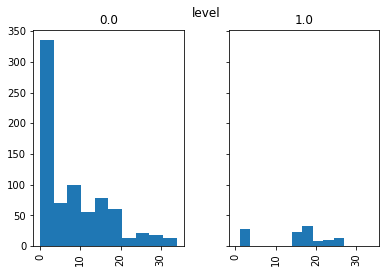

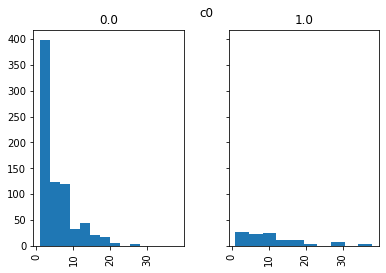

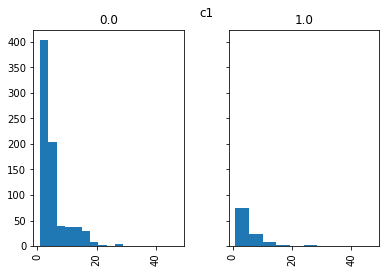

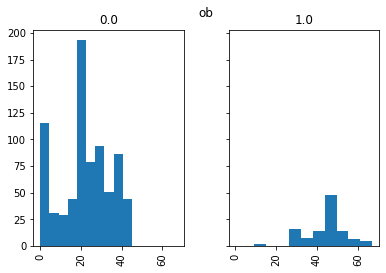

----------------10-----------------


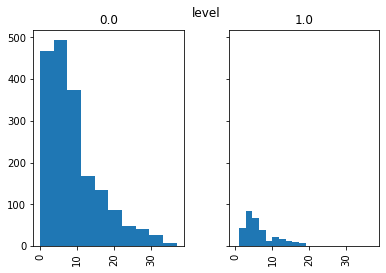

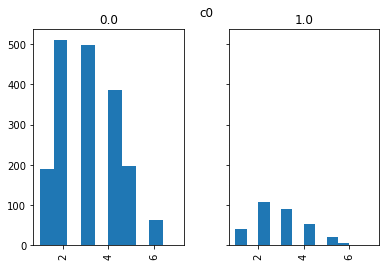

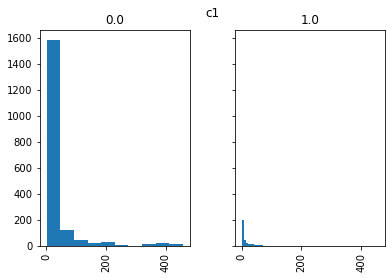

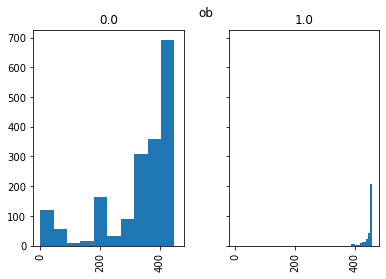

----------------11-----------------


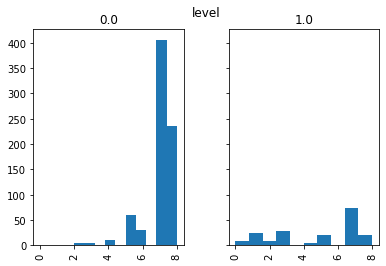

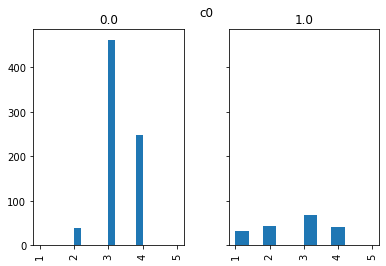

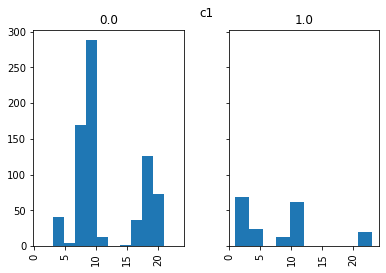

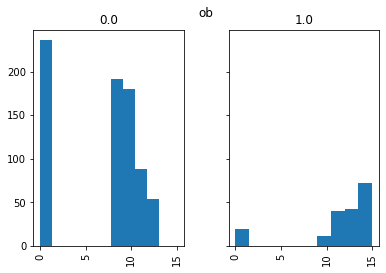

----------------12-----------------


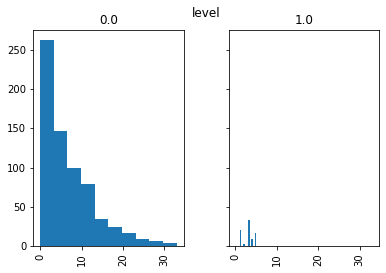

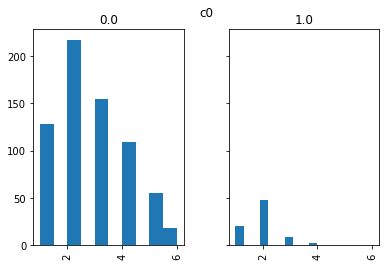

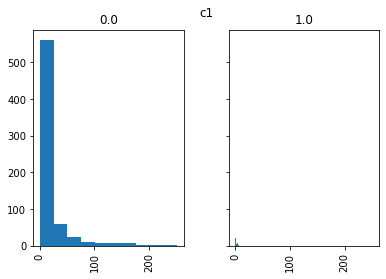

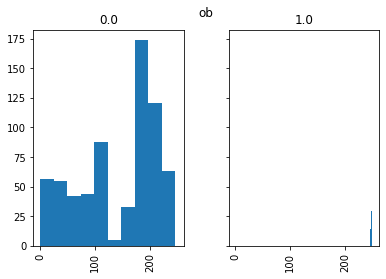

----------------13-----------------


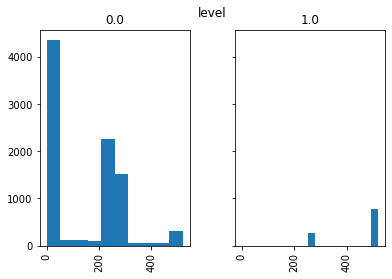

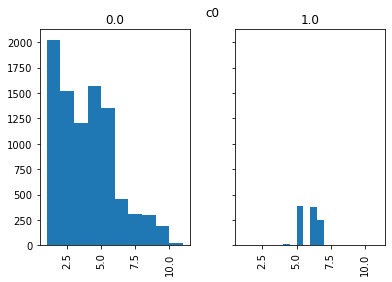

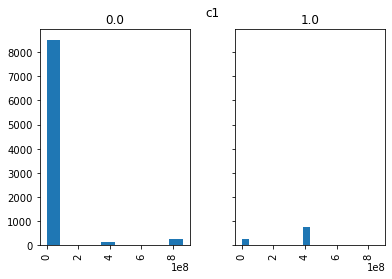

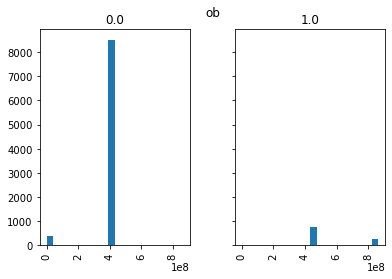

----------------14-----------------


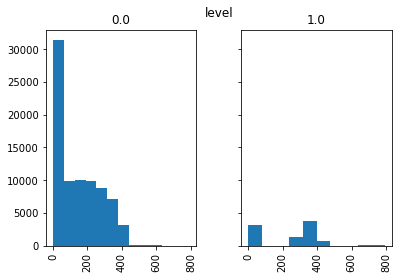

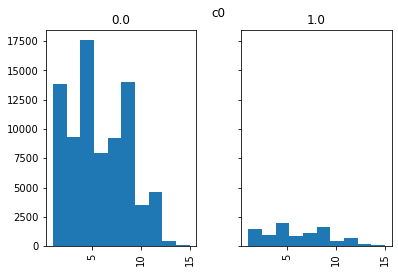

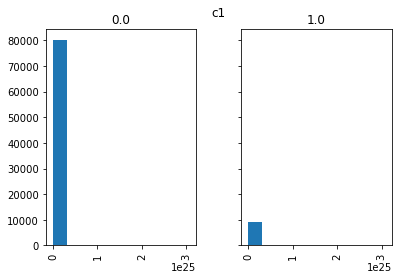

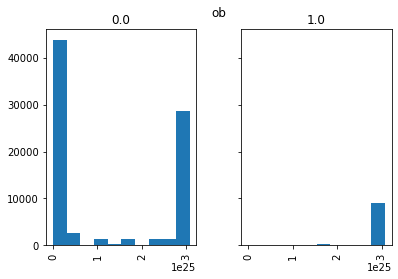

----------------15-----------------


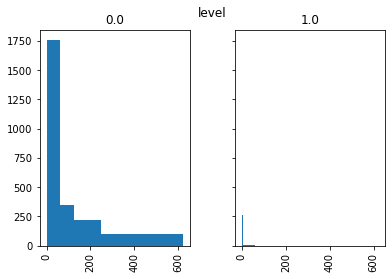

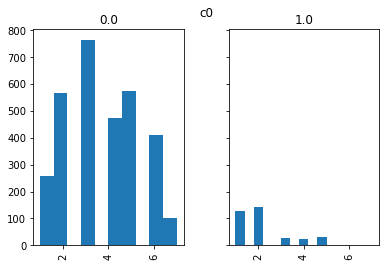

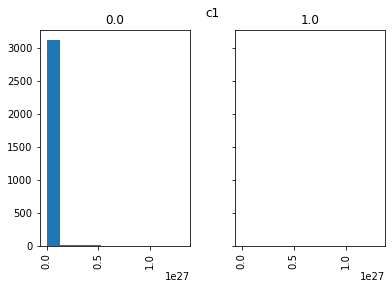

/Users/vedikasaravanan/opt/anaconda3/lib/python3.8/site-packages/numpy/lib/histograms.py:822: RuntimeWarning: divide by zero encountered in double_scalars
  norm = n_equal_bins / _unsigned_subtract(last_edge, first_edge)
/Users/vedikasaravanan/opt/anaconda3/lib/python3.8/site-packages/numpy/lib/histograms.py:850: RuntimeWarning: invalid value encountered in multiply
  f_indices = _unsigned_subtract(tmp_a, first_edge) * norm


IndexError: index -9223372036854775808 is out of bounds for axis 0 with size 11

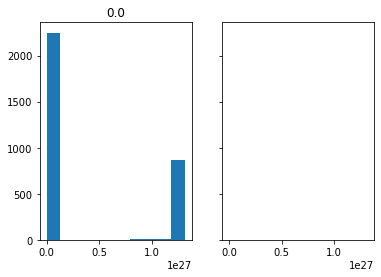

In [11]:
from matplotlib import pyplot as plt

for i, g in enumerate(dataset):
    print(f"----------------{i}-----------------")
    df_all_circ_data = pd.DataFrame(g.x, columns=['level', 'c0', 'c1', 'ob'])
    df_all_circ_data['y'] = g.y
    for col in ['level', 'c0', 'c1', 'ob']:
        df_all_circ_data.hist(by='y', column=col, sharex=True, sharey=True)
        plt.suptitle(col)
        plt.show()

In [ ]:
scaler = MinMaxScaler()
scaler.fit_transform(ds1[0].x).shape

In [ ]:
ds1[0].x